In [2]:
# abpc_dashboard.py
# Modular, fast dashboard for MoRF/LeRF + metrics table (reads metrics from run.summary).

from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
import wandb
from typing import Dict, List, Tuple, Optional
from scipy.ndimage import uniform_filter1d
import os

class ABPCDashboard:
    """
    Build a 2x2 matplotlib dashboard of MoRF/LeRF curves and a summary table
    (ABPC, AOPC, norm_ABPC, norm_AOPC); grouped by `aggregation_function`,
    filtered by group ('ABPC') and supervoxel type.

    x-axis modes:
      - 'absolute'    : truncate each subgroup to its common MIN length across runs (x = steps)
      - 'percent'     : resample each run to the subgroup's MAX length (or a fixed N points) (x = % of steps)
      - 'volume_pct'  : x = MoRF/LeRF_volume_removed_pct vs respective y values; overlaid in same axis
                       If percent_points is None (or <=0) we now use ALL observed percentage points (union across runs & MoRF/LeRF) per subgroup.
                       Otherwise we resample to a linear grid of that many points in [0,100].

    NOTE: This version DOES NOT recompute metrics. It reads from runs:
      - ABPC_area, AOPC, norm_ABPC, norm_AOPC from run.summary (if present)
    It also supports curve smoothing and two band types:
      - band_type='std'      -> center: mean, band: ±1 SD
      - band_type='quantile' -> center: median, band: [q, 1-q] percentiles (default q=0.25 -> IQR)

    Figures are split: one for plots, one for the table; saved separately.
    """

    # Colors (MoRF blue, LeRF red, purple gap)
    MORF_COLOR = "#1f77b4"
    LERF_COLOR = "#d62728"
    GAP_COLOR  = "purple"
    BAND_ALPHA = 0.18
    GAP_ALPHA  = 0.12

    def __init__(
        self,
        entity: str = "giuliosichili",
        project: str = "automi",
        group: str = "ABPC",
        subgroups: Optional[List[str]] = None,
        morf_key: str = "MoRF",
        lerf_key: str = "LeRF",
        abpc_key: str = "ABPC_area",
        aopc_key: str = "AOPC",
        norm_abpc_key: str = "norm_ABPC",
        norm_aopc_key: str = "norm_AOPC",
        page_size: int = 256,
        smoothing_window: int = 5,
        band_type: str = "quantile",   # "std" or "quantile"
        band_quantile: float = 0.25,     # for quantile bands -> [q, 1-q]
        alias_map: Optional[Dict[str, str]] = None,
        agg_alias_map: Optional[Dict[str, str]] = None,
    ):
        self.entity = entity
        self.project = project
        self.group = group
        self.subgroups = subgroups or [
            "true_positive_aggregation",
            "false_positive_aggregation",
            "dice_aggregation",
            "logit_difference_aggregation",
        ]
        # prefer the new x; fall back to older name or _step if missing
        self.X_KEY = "supervoxels_perturbed"
        self.X_FALLBACKS = ("_step",)  # optional, keep if you used it before

        # Preferred (signed) keys first, then fall back
        self.SIGNED_MORF_KEY = "signed_MoRF"
        self.SIGNED_LERF_KEY = "signed_LeRF"
        self.MORF_KEY = morf_key
        self.LERF_KEY = lerf_key

        # Alt x metrics (volume %)
        self.MORF_X_VOL_PCT = "MoRF_volume_removed_pct"
        self.LERF_X_VOL_PCT = "LeRF_volume_removed_pct"

        self.ABPC_KEY = abpc_key
        self.AOPC_KEY = aopc_key
        self.NORM_ABPC_KEY = norm_abpc_key
        self.NORM_AOPC_KEY = norm_aopc_key
        self.PAGE_SIZE = page_size

        # Smoothing and bands
        self.smoothing_window = smoothing_window
        self.band_type = band_type
        self.band_quantile = band_quantile

        # Human-friendly labels (supervoxel types)
        self.alias_map = alias_map or {
            "full-organs": "Full organs",
            "FCC": "Regular",
            "FCC-organs": "Hybrid",
        }
        # Human-friendly labels (aggregation functions)
        self.agg_alias = agg_alias_map or {
            "true_positive_aggregation": "True Positive",
            "false_positive_aggregation": "False Positive",
            "dice_aggregation": "Dice",
            "logit_difference_aggregation": "Soft Dice",
        }

        self._api = wandb.Api()

        # Caches for computed grouped data
        self._cache_grouped: Dict[Tuple[str, str, Optional[int]], Dict[str, Dict]] = {}
        self._cache_comparison: Dict[Tuple[Tuple[str, ...], Optional[int]], Dict[str, Dict[str, Dict]]] = {}

    # ---------- Public API ----------

    def compute_grouped(
        self,
        supervoxel_type: str,
        x_mode: str = "absolute",
        percent_points: Optional[int] = None,
        use_cache: bool = True,
    ) -> Dict[str, Dict]:
        """Compute and return grouped curves+metrics for a given supervoxel type.
        Results are cached by (supervoxel_type, x_mode, percent_points).

        For x_mode='volume_pct':
          - If percent_points is None or <=0: use all observed % points (union across runs & MoRF/LeRF) per aggregation.
          - Else: resample to linear grid of `percent_points` in [0,100].
        """
        key = (supervoxel_type, x_mode, int(percent_points) if percent_points else None)
        if use_cache and key in self._cache_grouped:
            return self._cache_grouped[key]
        runs = self._fetch_runs(supervoxel_type)
        grouped = self._collect_curves_and_metrics(runs, x_mode=x_mode, percent_points=percent_points)
        self._cache_grouped[key] = grouped
        return grouped

    def plot_grouped(
        self,
        grouped: Dict[str, Dict],
        supervoxel_type: str,
        x_mode: str,
        save: bool = True,
        dpi: int = 300,
        smoothing_window: Optional[int] = None,
        band: Optional[str] = None,
        quantile: Optional[float] = None,
    ):
        """Create the plots and table figures from precomputed grouped data."""
        # Resolve visualization params (override defaults if provided)
        window = self.smoothing_window if smoothing_window is None else int(smoothing_window)
        band_type = (band or self.band_type).lower()
        q = self.band_quantile if quantile is None else float(quantile)
        if band_type == "quantile":
            if not (0.0 < q <= 0.5):
                print(f"[warning] invalid quantile {q}, using 0.25")
                q = 0.25

        fig_plots = self._plot(grouped, supervoxel_type, x_mode, window, band_type, q)
        fig_table = self._create_table_figure(grouped, supervoxel_type, x_mode)

        if save:
            os.makedirs("figures", exist_ok=True)
            safe_sv = supervoxel_type.replace(" ", "_")
            fname_plots = f"abpc_plots_{x_mode}_{safe_sv}.png"
            fname_table = f"abpc_table_{x_mode}_{safe_sv}.png"
            fig_plots.savefig(os.path.join("figures", fname_plots), dpi=dpi, bbox_inches="tight")
            fig_table.savefig(os.path.join("figures", fname_table), dpi=dpi, bbox_inches="tight")
            print(f"[saved] figures/{fname_plots}")
            print(f"[saved] figures/{fname_table}")
        plt.show()
        return fig_plots, fig_table

    def compute_comparison_grouped(
        self,
        supervoxel_types: Optional[List[str]] = None,
        percent_points: Optional[int] = None,
        use_cache: bool = False,
    ) -> Dict[str, Dict[str, Dict]]:
        """Compute grouped data for multiple supervoxel types (volume % axis).
        Returns a mapping: {sv_type: grouped_dict}.
        Cached by (tuple(sorted(sv_list)), percent_points) if use_cache.
        """
        sv_list = tuple(supervoxel_types or ['full-organs', 'FCC', 'FCC-organs'])
        key = (tuple(sorted(sv_list)), int(percent_points) if percent_points else None)
        if use_cache and key in self._cache_comparison:
            return self._cache_comparison[key]
        out: Dict[str, Dict[str, Dict]] = {}
        for sv in sv_list:
            out[sv] = self.compute_grouped(sv, x_mode='volume_pct', percent_points=percent_points, use_cache=use_cache)
        self._cache_comparison[key] = out
        return out

    def run(
        self,
        supervoxel_type: str,
        x_mode: str = "absolute",
        percent_points: Optional[int] = None,
        save: bool = True,
        dpi: int = 300,
        smoothing_window: Optional[int] = None,
        band: Optional[str] = None,            # "std" or "quantile"
        quantile: Optional[float] = None,      # if band == "quantile": use [q, 1-q]
    ):
        grouped = self.compute_grouped(supervoxel_type, x_mode=x_mode, percent_points=percent_points, use_cache=False)
        return self.plot_grouped(
            grouped,
            supervoxel_type=supervoxel_type,
            x_mode=x_mode,
            save=save,
            dpi=dpi,
            smoothing_window=smoothing_window,
            band=band,
            quantile=quantile,
        )

    # ---------- Internals ----------

    def _fetch_runs(self, supervoxel_type: str) -> List[wandb.apis.public.Run]:
        path = f"{self.entity}/{self.project}"
        filt = {
            "config.group": {"$eq": self.group},
            "config.supervoxel_type": {"$eq": supervoxel_type},
            "config.aggregation_function": {"$in": self.subgroups},
        }
        return list(self._api.runs(path, filters=filt))

    @staticmethod
    def _resample_to_length(y: np.ndarray, L_target: int) -> np.ndarray:
        L_run = len(y)
        if L_run <= 0:
            return np.zeros(L_target, dtype=float)
        if L_run == 1:
            return np.full(L_target, float(y[0]), dtype=float)
        x_src = np.linspace(0.0, 1.0, L_run)
        x_tgt = np.linspace(0.0, 1.0, L_target)
        return np.interp(x_tgt, x_src, y)

    def _collect_curves_and_metrics(
        self,
        runs: List[wandb.apis.public.Run],
        x_mode: str,
        percent_points: Optional[int],
    ) -> Dict[str, Dict]:
        assert x_mode in {"absolute", "percent", "volume_pct"}

        curves_raw: Dict[str, List[np.ndarray]] = {sg: [] for sg in self.subgroups}   # y values stacked (L,2) AFTER resampling
        lengths: Dict[str, List[int]] = {sg: [] for sg in self.subgroups}
        xgrids_raw: Dict[str, List[np.ndarray]] = {sg: [] for sg in self.subgroups}   # for step/percent original x grids

        abpc_vals: Dict[str, List[float]] = {sg: [] for sg in self.subgroups}
        aopc_vals: Dict[str, List[float]] = {sg: [] for sg in self.subgroups}
        n_abpc_vals: Dict[str, List[float]] = {sg: [] for sg in self.subgroups}
        n_aopc_vals: Dict[str, List[float]] = {sg: [] for sg in self.subgroups}

        # Track the maximum observed volume % per subgroup (for axis limits)
        x_max_actual: Dict[str, float] = {sg: 0.0 for sg in self.subgroups} if x_mode == "volume_pct" else {}

        # For volume_pct new approach: store raw MoRF/LeRF x,y before deciding common grid
        raw_volume: Dict[str, List[Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]]] = {sg: [] for sg in self.subgroups} if x_mode == "volume_pct" else {}

        for r in runs:
            sg = (r.config or {}).get("aggregation_function")
            if sg not in curves_raw:
                continue

            # read metrics from summary
            summ = r.summary or {}
            def _get_float(k):
                v = summ.get(k)
                try:
                    return float(v) if v is not None else None
                except Exception:
                    return None

            abpc = _get_float(self.ABPC_KEY)
            aopc = _get_float(self.AOPC_KEY)
            n_abpc = _get_float(self.NORM_ABPC_KEY)
            n_aopc = _get_float(self.NORM_AOPC_KEY)

            if abpc is not None:   abpc_vals[sg].append(abpc)
            if aopc is not None:   aopc_vals[sg].append(aopc)
            if n_abpc is not None: n_abpc_vals[sg].append(n_abpc)
            if n_aopc is not None: n_aopc_vals[sg].append(n_aopc)

            # gather curves
            if x_mode == "volume_pct":
                morf_x_list, morf_y_list = [], []
                lerf_x_list, lerf_y_list = [], []
                for row in r.scan_history(page_size=self.PAGE_SIZE):
                    xm = row.get(self.MORF_X_VOL_PCT)
                    ym = row.get(self.SIGNED_MORF_KEY, row.get(self.MORF_KEY))
                    if xm is not None and ym is not None:
                        try:
                            morf_x_list.append(float(xm))
                            morf_y_list.append(float(ym))
                        except Exception:
                            pass
                    xl = row.get(self.LERF_X_VOL_PCT)
                    yl = row.get(self.SIGNED_LERF_KEY, row.get(self.LERF_KEY))
                    if xl is not None and yl is not None:
                        try:
                            lerf_x_list.append(float(xl))
                            lerf_y_list.append(float(yl))
                        except Exception:
                            pass
                if len(morf_x_list) < 2 or len(lerf_x_list) < 2:
                    continue
                xm = np.array(morf_x_list, dtype=float)
                ym = np.array(morf_y_list, dtype=float)
                xl = np.array(lerf_x_list, dtype=float)
                yl = np.array(lerf_y_list, dtype=float)
                m_mask = np.isfinite(xm) & np.isfinite(ym)
                l_mask = np.isfinite(xl) & np.isfinite(yl)
                xm, ym = xm[m_mask], ym[m_mask]
                xl, yl = xl[l_mask], yl[l_mask]
                if xm.size < 2 or xl.size < 2:
                    continue
                m_ord = np.argsort(xm)
                l_ord = np.argsort(xl)
                xm, ym = xm[m_ord], ym[m_ord]
                xl, yl = xl[l_ord], yl[l_ord]
                run_x_max = float(max(xm[-1] if xm.size else 0.0, xl[-1] if xl.size else 0.0))
                x_max_actual[sg] = max(x_max_actual[sg], run_x_max)
                raw_volume[sg].append((xm, ym, xl, yl))
            else:
                morf_vals, lerf_vals = {}, {}
                for row in r.scan_history(page_size=self.PAGE_SIZE):
                    # choose x value
                    x = row.get(self.X_KEY, None)
                    if x is None:
                        for fb in self.X_FALLBACKS:
                            x = row.get(fb, None)
                            if x is not None:
                                break
                    if x is None:
                        x = row.get("_step", row.get("step"))
                    try:
                        x = int(x)
                    except Exception:
                        try:
                            x = int(float(x))
                        except Exception:
                            continue

                    # prefer corrected/signed keys; fall back to original
                    m = row.get(self.SIGNED_MORF_KEY, row.get(self.MORF_KEY))
                    l = row.get(self.SIGNED_LERF_KEY, row.get(self.LERF_KEY))

                    if m is not None:
                        try: morf_vals[x] = float(m)
                        except Exception: pass
                    if l is not None:
                        try: lerf_vals[x] = float(l)
                        except Exception: pass

                common = sorted(set(morf_vals.keys()) & set(lerf_vals.keys()))
                xgrids_raw[sg].append(np.array(common, dtype=int))
                if len(common) >= 1:
                    morf_seq = np.array([morf_vals[s] for s in common], dtype=float)
                    lerf_seq = np.array([lerf_vals[s] for s in common], dtype=float)
                    seq = np.stack([morf_seq, lerf_seq], axis=1)  # (L_run, 2)
                    curves_raw[sg].append(seq)
                    lengths[sg].append(len(common))

        grouped: Dict[str, Dict] = {
            sg: {
                "curves": np.empty((0, 2, 2), dtype=float),
                "x": None,          # step/percent or shared grid for volume_pct
                "x_max": None,      # max observed % (volume_pct)
                "abpc_values": abpc_vals[sg],
                "aopc_values": aopc_vals[sg],
                "norm_abpc_values": n_abpc_vals[sg],
                "norm_aopc_values": n_aopc_vals[sg],
            }
            for sg in self.subgroups
        }

        for sg in self.subgroups:
            if x_mode == "absolute":
                seqs = curves_raw[sg]
                if not seqs:
                    continue
                L = min(lengths[sg])
                seqs_trunc = [seq[:L] for seq in seqs]
                grouped[sg]["curves"] = np.stack(seqs_trunc, axis=0)
                xs_trunc = np.stack([xs[:L] for xs in xgrids_raw[sg]], axis=0)  # (n, L)
                grouped[sg]["x"] = np.median(xs_trunc, axis=0)
            elif x_mode == "percent":
                seqs = curves_raw[sg]
                if not seqs:
                    continue
                L_target = percent_points if (percent_points and percent_points > 1) else max(lengths[sg])
                resampled = []
                for seq in seqs:
                    morf_rs = self._resample_to_length(seq[:, 0], L_target)
                    lerf_rs = self._resample_to_length(seq[:, 1], L_target)
                    resampled.append(np.stack([morf_rs, lerf_rs], axis=1))
                grouped[sg]["curves"] = np.stack(resampled, axis=0)
                grouped[sg]["x"] = np.linspace(0, 100, L_target)
            else:  # volume_pct
                raw_list = raw_volume[sg]
                if not raw_list:
                    continue
                # Decide target grid
                if percent_points is None or (isinstance(percent_points, (int, float)) and percent_points <= 0):
                    # Use union of all observed x (MoRF & LeRF) across runs
                    all_x = []
                    for (xm, _, xl, _) in raw_list:
                        all_x.append(xm)
                        all_x.append(xl)
                    if all_x:
                        union = np.unique(np.round(np.concatenate(all_x), 6))
                    else:
                        union = np.linspace(0, 100, 101)
                    x_target = union
                else:
                    L_target = int(percent_points) if percent_points and percent_points > 1 else 101
                    x_target = np.linspace(0.0, 100.0, L_target)

                seqs_resampled: List[np.ndarray] = []
                for (xm, ym, xl, yl) in raw_list:
                    # interpolate (clamp using end values)
                    ym_rs = np.interp(x_target, xm, ym)
                    yl_rs = np.interp(x_target, xl, yl)
                    seqs_resampled.append(np.stack([ym_rs, yl_rs], axis=1))
                grouped[sg]["curves"] = np.stack(seqs_resampled, axis=0)
                grouped[sg]["x"] = x_target
                grouped[sg]["x_max"] = min(100.0, float(x_max_actual.get(sg, 100.0)))

        return grouped

    def _smooth_curve(self, y: np.ndarray, window_size: int) -> np.ndarray:
        """Apply smoothing to a curve using a nan-aware moving average.
        - Clips window_size to length of y.
        - Ensures odd window for symmetry.
        - Interpolates internal NaNs before smoothing (keeps leading/trailing NaNs if all NaN).
        """
        if window_size is None or window_size <= 1:
            return y
        n = len(y)
        if n < 3:
            return y
        window_size = min(int(window_size), n)
        if window_size % 2 == 0 and window_size > 1:
            window_size -= 1  # odd for symmetry
        y = y.astype(float)
        isnan = np.isnan(y)
        if isnan.all():
            return y
        if isnan.any():
            idx = np.arange(n)
            good = ~isnan
            y_interp = y.copy()
            y_interp[isnan] = np.interp(idx[isnan], idx[good], y[good])
        else:
            y_interp = y
        return uniform_filter1d(y_interp, size=window_size, mode='nearest')

    def _summarize_curves(
        self,
        curves: np.ndarray,
        band_type: str,
        q: float,
        window_size: int,
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Summarize across runs at each step using chosen band.
        Returns morf_center, morf_lo, morf_hi, lerf_center, lerf_lo, lerf_hi
        """
        if curves.size == 0:
            z = np.zeros(0)
            return z, z, z, z, z, z
        morf = curves[:, :, 0]  # (R, L)
        lerf = curves[:, :, 1]
        b = band_type.lower()
        if b == "std":
            morf_c = np.nanmean(morf, axis=0)
            lerf_c = np.nanmean(lerf, axis=0)
            with np.errstate(invalid="ignore"):
                morf_sd = np.nanstd(morf, axis=0, ddof=1)
                lerf_sd = np.nanstd(lerf, axis=0, ddof=1)
            morf_lo, morf_hi = morf_c - np.nan_to_num(morf_sd), morf_c + np.nan_to_num(morf_sd)
            lerf_lo, lerf_hi = lerf_c - np.nan_to_num(lerf_sd), lerf_c + np.nan_to_num(lerf_sd)
        else:
            # quantile band [q, 1-q] with median center
            morf_c = np.nanmedian(morf, axis=0)
            lerf_c = np.nanmedian(lerf, axis=0)
            morf_lo = np.nanpercentile(morf, q * 100.0, axis=0)
            morf_hi = np.nanpercentile(morf, (1.0 - q) * 100.0, axis=0)
            lerf_lo = np.nanpercentile(lerf, q * 100.0, axis=0)
            lerf_hi = np.nanpercentile(lerf, (1.0 - q) * 100.0, axis=0)

        # Smooth all
        def sm(a):
            return self._smooth_curve(a, window_size)
        return sm(morf_c), sm(morf_lo), sm(morf_hi), sm(lerf_c), sm(lerf_lo), sm(lerf_hi)

    @staticmethod
    def _fmt_cell(mu: float, sd: float, normalized: bool = False) -> str:
        if mu is None or (isinstance(mu, float) and np.isnan(mu)):
            return "–"
        if normalized:
            if sd is None or (isinstance(sd, float) and np.isnan(sd)):
                return f"{mu:.4f}"
            return f"{mu:.4f} ± {sd:.4f}"
        else:
            if sd is None or (isinstance(sd, float) and np.isnan(sd)):
                return f"{mu:.3e}"
            return f"{mu:.3e} ± {sd:.1e}"

    def _plot(self, grouped: Dict[str, Dict], supervoxel_type: str, x_mode: str, window_size: int, band_type: str, q: float):
        fig, axes = plt.subplots(2, 2, figsize=(12, 10.5), sharex=False, sharey=False)
        axes = axes.ravel()

        for ax, sg in zip(axes, self.subgroups):
            curves = grouped[sg]["curves"]
            if curves.size == 0:
                ax.set_title(self.agg_alias.get(sg, sg) + " (no data)")
                ax.grid(True, alpha=0.25)
                continue

            x_vals = grouped[sg].get("x", None)
            if x_vals is None:
                L = curves.shape[1]
                x_vals = np.arange(L)

            if x_mode == "volume_pct":
                x_label = "Volume removed (%)"
            else:
                x_label = "Percent of supervoxels removed" if x_mode == "percent" else "Supervoxels removed"

            morf_c, morf_lo, morf_hi, lerf_c, lerf_lo, lerf_hi = self._summarize_curves(curves, band_type, q, window_size)

            ax.fill_between(x_vals, morf_lo, morf_hi, color=self.MORF_COLOR, alpha=self.BAND_ALPHA)
            ax.fill_between(x_vals, lerf_lo, lerf_hi, color=self.LERF_COLOR, alpha=self.BAND_ALPHA)

            center_lab = "mean" if band_type == "std" else "median"
            ax.plot(x_vals, morf_c, linewidth=2.0, color=self.MORF_COLOR, label=f"MoRF ({center_lab})")
            ax.plot(x_vals, lerf_c, linewidth=2.0, color=self.LERF_COLOR, label=f"LeRF ({center_lab})")

            # Only fill the inter-curve gap when x grids match (they do here)
            gap_low  = np.minimum(morf_c, lerf_c)
            gap_high = np.maximum(morf_c, lerf_c)
            ax.fill_between(x_vals, gap_low, gap_high, color=self.GAP_COLOR, alpha=self.GAP_ALPHA)

            # Limit x-axis to the maximum observed percentage in the data (volume_pct)
            if x_mode == "volume_pct":
                xmax_obs = grouped[sg].get("x_max", None)
                if isinstance(xmax_obs, (int, float)) and xmax_obs > 0:
                    ax.set_xlim(0, xmax_obs)

            band_txt = ("±1 SD" if band_type == "std" else f"{int(q*100)}–{int((1-q)*100)} pct")
            ax.set_title(f"{self.agg_alias.get(sg, sg)} (center: {center_lab}, band: {band_txt}, smooth w={window_size})")
            ax.grid(True, alpha=0.25)
            ax.set_xlabel(x_label)
            ax.set_ylabel("Score")

        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.05))

        title_mode = {
            "absolute": "absolute steps",
            "percent": "% steps",
            "volume_pct": "volume %",
        }.get(x_mode, x_mode)
        sv_label = self.alias_map.get(supervoxel_type, supervoxel_type)
        center_txt = ("Mean ± SD" if band_type == "std" else f"Median + [{int(q*100)}–{int((1-q)*100)}] pct band")
        fig.suptitle(f"ABPC — MoRF/LeRF ({center_txt}, {title_mode}) by Aggregation — SV: {sv_label}",
                     y=0.975, fontsize=14)

        fig.tight_layout(rect=[0.02, 0.05, 0.98, 0.90])
        return fig

    def _create_table_figure(self, grouped: Dict[str, Dict], supervoxel_type: str, x_mode: str) -> plt.Figure:
        fig, ax = plt.subplots(figsize=(10.5, 3.8))
        ax.axis('off')

        row_labels = [self.agg_alias.get(sg, sg) for sg in self.subgroups]
        col_labels = ["ABPC", "AOPC", "norm_ABPC", "norm_AOPC"]
        cell_text = []

        for sg in self.subgroups:
            def _mean_std(vals: List[float]):
                if not vals:
                    return (np.nan, np.nan)
                arr = np.array(vals, dtype=float)
                mu = np.nanmean(arr)
                sd = np.nanstd(arr, ddof=1) if arr.size > 1 else np.nan
                return (mu, sd)

            mu_abpc, sd_abpc   = _mean_std(grouped[sg]["abpc_values"])
            mu_aopc, sd_aopc   = _mean_std(grouped[sg]["aopc_values"])
            mu_nabp, sd_nabp   = _mean_std(grouped[sg]["norm_abpc_values"])
            mu_naop, sd_naop   = _mean_std(grouped[sg]["norm_aopc_values"])

            row = [
                self._fmt_cell(mu_abpc, sd_abpc, normalized=False),
                self._fmt_cell(mu_aopc, sd_aopc, normalized=False),
                self._fmt_cell(mu_nabp, sd_nabp, normalized=True),
                self._fmt_cell(mu_naop, sd_naop, normalized=True),
            ]
            cell_text.append(row)

        table = ax.table(
            cellText=cell_text,
            rowLabels=row_labels,
            colLabels=col_labels,
            cellLoc='center',
            loc='center'
        )
        table.scale(1.0, 1.1)
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        for (row, col), cell in table.get_celld().items():
            if row == 0:
                cell.set_text_props(weight='bold')

        title_mode = {
            "absolute": "absolute steps",
            "percent": "% steps",
            "volume_pct": "volume %",
        }.get(x_mode, x_mode)
        sv_label = self.alias_map.get(supervoxel_type, supervoxel_type)
        fig.suptitle(f"ABPC — Summary Metrics (by Aggregation) — {title_mode} — SV: {sv_label}", y=0.96)
        fig.tight_layout(rect=[0.02, 0.02, 0.98, 0.90])
        return fig

In [7]:
dash = ABPCDashboard(entity="giuliosichili", project="automi", group="ABPC-volumes", smoothing_window=0, band_type="quantile", band_quantile=0.25)

wandb: Currently logged in as: giuliosichili to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


[saved] abpc_plots_absolute_full-organs.png
[saved] abpc_table_absolute_full-organs.png


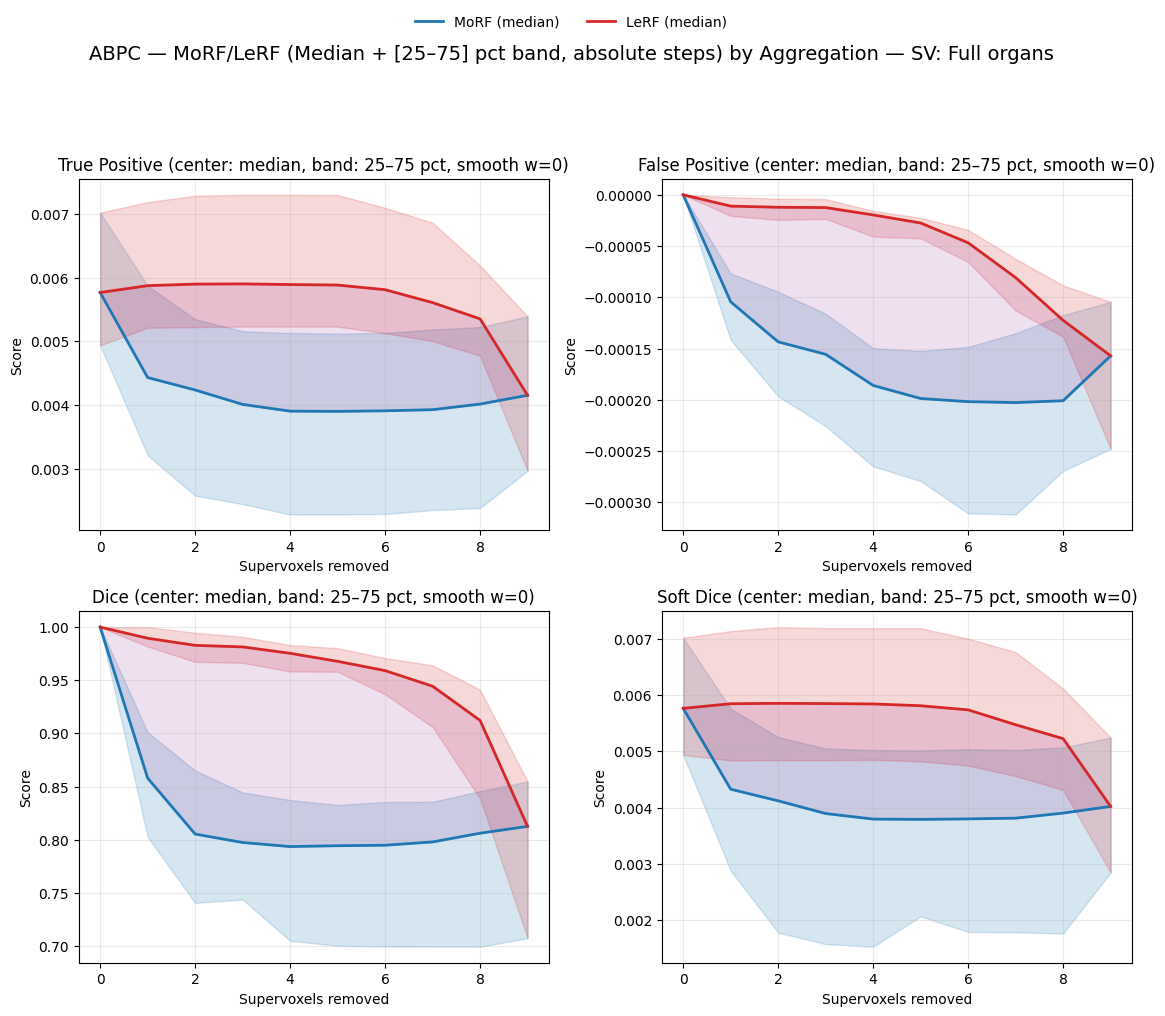

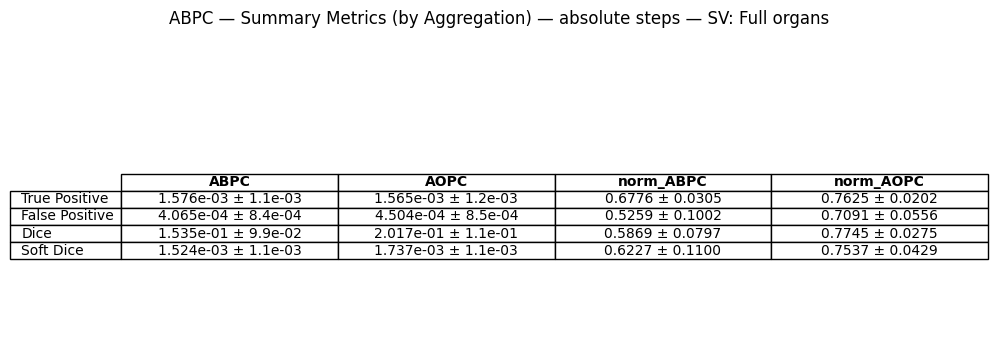

(<Figure size 1200x1050 with 4 Axes>, <Figure size 1050x380 with 1 Axes>)

In [43]:
dash.run(supervoxel_type="full-organs", x_mode="absolute", save=True, smoothing_window=0, band="quantile", quantile=0.25)         # truncate to min length

## Save some observations about starting and ending points!

* the two curves start and end in the same point (all on and all off respectively)
* FP aggr. starts on 0, as there can't be spurious predictions for the original input with respect to itself
* Dice Aggregation starts on 1, because the baseline volume produces perfect overlapping with itself.
* By construction, Soft Dice aggregation is equal to the sum of True Positive and False Positive aggregations; this by itself doesn't imply that each plot will exactly match this relationship, but in the following plots we can empirically verify that it is.
** as a direct consequence of 1 and 3, TP and Soft Dice start on the same point, here 0.0058 approximately. This is because for the unperturbed volume, all the logits are in the baseline segmentation mask, so their sum is equal to the sum returned by True Positive mask.

these observation can seem of limited interest, but they strengthen the reliability of these new defined metrics as the behavior is the one expected, and they pose the basis to correctly interpret these plots.

## Other observations
* TP plot is very regular, in the sense that LeRF and MoRF curves are mostly simmetric around a point between them. This suggests that this notion of importance, given by preservation of predicted regions, is the most natural from a perspective that considers additivity of the parts (organs in this case) important, and also imply little feature interactions since attribution order is well respected in these plots.
* FP range, which is scaled equally to TP and Logit Difference and it's a logit sum like them, so it's comparable as unit, is very low compared to them. This shows limited spurious lymph nodes predictions, at least not close to baseline segmentation mask mass.
* Dice and LogDiff show a similar shape, and it's expected since the second is a continuous version of the first. We notice a decreasing monotonic behavior in LeRF curve, while the MoRF shows a decreasing and then increasing plot in the least important organs.


[saved] abpc_plots_percent_FCC-organs.png
[saved] abpc_table_percent_FCC-organs.png


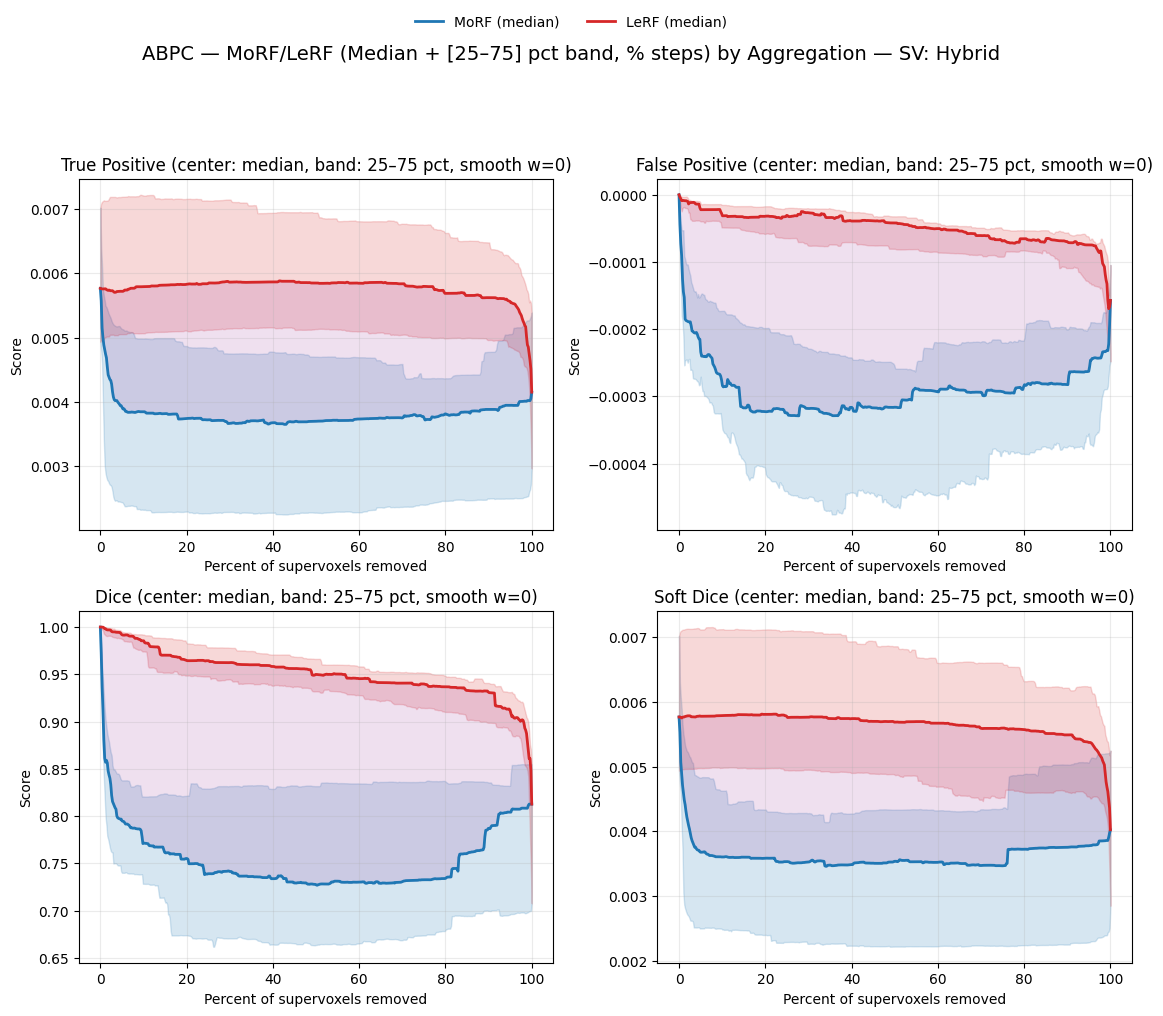

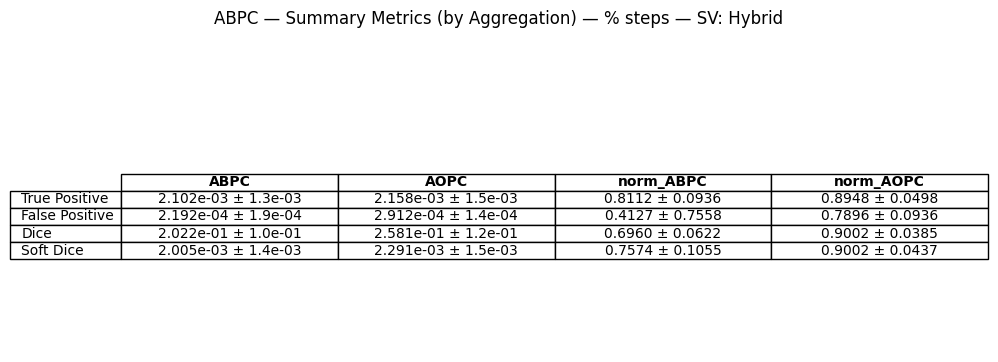

(<Figure size 1200x1050 with 4 Axes>, <Figure size 1050x380 with 1 Axes>)

In [44]:
dash.run(supervoxel_type="FCC-organs", x_mode="percent", save=True, smoothing_window=0, band="quantile", quantile=0.25)           # interpolate to subgroup max

In [8]:
# Extend ABPCDashboard with a comparison figure across supervoxel types (volume % axis)

def compute_supervoxel_comparison_grouped(self, supervoxel_types=None, percent_points=None, use_cache: bool = False):
    return self.compute_comparison_grouped(supervoxel_types=supervoxel_types, percent_points=percent_points, use_cache=use_cache)

def plot_supervoxel_comparison_from_grouped(self,
                                            grouped_by_sv: dict,
                                            save: bool = True,
                                            dpi: int = 300,
                                            smoothing_window: int | None = None,
                                            band: str | None = None,
                                            quantile: float | None = None):
    """
    Plot supervoxel comparison per aggregation using precomputed grouped data.
    Supports adaptive (non-linear, union-of-observed) x grids when percent_points=None
    in the original compute step.

    Uses a logarithmic x-axis on (percent + 1) so that 0% is representable,
    and shows ticks labeled as 0, 2, 5, 10, 20, 50, 100.

    NOTE: Hardcoded fix — for (aggregation == false_positive_aggregation) and (supervoxel == 'FCC-organs'),
    swap MoRF and LeRF centers (and bands if used), as signed curves were stored only there.
    """
    window = self.smoothing_window if smoothing_window is None else int(smoothing_window)
    band_type = (band or self.band_type).lower()
    q = self.band_quantile if quantile is None else float(quantile)
    if band_type == 'quantile' and not (0.0 < q <= 0.5):
        print(f"[warning] invalid quantile {q}, using 0.25")
        q = 0.25

    import matplotlib.pyplot as plt
    import os
    base_cycle = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['#1f77b4', '#ff7f0e', '#2ca02c'])

    sv_list = list(grouped_by_sv.keys())
    ordered_keys = ['FCC', 'full-organs', 'FCC-organs']
    sv_palette = {}
    idx = 0
    for k in ordered_keys:
        if k in grouped_by_sv:
            sv_palette[k] = base_cycle[idx % len(base_cycle)] if base_cycle else '#000000'
            idx += 1
    for sv in sv_list:
        if sv not in sv_palette:
            sv_palette[sv] = base_cycle[idx % len(base_cycle)] if base_cycle else '#000000'
            idx += 1

    fig, axes = plt.subplots(2, 2, figsize=(12, 10.5), sharex=False, sharey=False)
    axes = axes.ravel()

    for ax, sg in zip(axes, self.subgroups):
        any_plotted = False
        for sv in sv_list:
            g = grouped_by_sv.get(sv, {})
            data = g.get(sg)
            if not data:
                continue
            curves = data.get('curves')
            if curves is None or curves.size == 0:
                continue
            x_vals = data.get('x', None)
            if x_vals is None:
                x_vals = np.arange(curves.shape[1])

            morf_c, morf_lo, morf_hi, lerf_c, lerf_lo, lerf_hi = self._summarize_curves(
                curves, band_type, q, window
            )

            if sg == 'false_positive_aggregation' and sv == 'FCC-organs':
                morf_c, lerf_c = lerf_c, morf_c
                morf_lo, lerf_lo = lerf_lo, morf_lo
                morf_hi, lerf_hi = lerf_hi, morf_hi

            x_raw = np.asarray(x_vals, dtype=float)
            x_plot = x_raw + 1.0

            color = sv_palette.get(sv, '#000000')
            sv_label = self.alias_map.get(sv, sv)

            ax.plot(x_plot, morf_c, color=color, linewidth=2.0, linestyle='-',  label=f"{sv_label} — MoRF")
            ax.plot(x_plot, lerf_c, color=color, linewidth=2.0, linestyle='--', label=f"{sv_label} — LeRF")

            any_plotted = True

        title_txt = self.agg_alias.get(sg, sg)
        if not any_plotted:
            title_txt += " (no data)"
        ax.set_title(title_txt)
        ax.grid(True, alpha=0.25)
        ax.set_xlabel('Volume removed (%)')
        ax.set_ylabel('Score')

        ax.set_xscale('log')
        ax.set_xlim(1.0, 101.0)

        tick_locs = [1.0, 3.0, 6.0, 11.0, 21.0, 51.0, 101.0]
        tick_labels = ['0', '2', '5', '10', '20', '50', '100']
        ax.set_xticks(tick_locs)
        ax.set_xticklabels(tick_labels)
        ax.minorticks_off()

    handles_by_label = {}
    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        for hi, li in zip(h, l):
            handles_by_label[li] = hi
    if handles_by_label:
        fig.legend(list(handles_by_label.values()), list(handles_by_label.keys()),
                   loc='upper center', ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.05))

    fig.suptitle('ABPC — Supervoxel comparison (volume %, log x-axis) by Aggregation', y=0.975, fontsize=14)
    fig.tight_layout(rect=[0.02, 0.05, 0.98, 0.90])

    if save:
        os.makedirs('figures', exist_ok=True)
        out = os.path.join('figures', 'abpc_plots_volume_pct_supervoxel_comparison.png')
        fig.savefig(out, dpi=dpi, bbox_inches='tight')
        print(f"[saved] {out}")

    plt.show()
    return fig

ABPCDashboard.compute_supervoxel_comparison_grouped = compute_supervoxel_comparison_grouped
ABPCDashboard.plot_supervoxel_comparison_from_grouped = plot_supervoxel_comparison_from_grouped

In [85]:
# Extend ABPCDashboard with a comparison figure across supervoxel types (volume % axis)

def compute_supervoxel_comparison_grouped(self, supervoxel_types=None, percent_points=None, use_cache: bool = False):
    return self.compute_comparison_grouped(supervoxel_types=supervoxel_types, percent_points=percent_points, use_cache=use_cache)

def plot_supervoxel_comparison_from_grouped(self,
                                            grouped_by_sv: dict,
                                            save: bool = True,
                                            dpi: int = 300,
                                            smoothing_window: int | None = None,
                                            band: str | None = None,
                                            quantile: float | None = None):
    """
    Plot supervoxel comparison per aggregation using precomputed grouped data.
    Uses a logarithmic x-axis on (percent + 1) so that 0% is representable,
    and shows ticks labeled as 0, 2, 5, 10, 20, 50, 100.

    NOTE: Hardcoded fix — for (aggregation == false_positive_aggregation) and (supervoxel == 'FCC-organs'),
    swap MoRF and LeRF centers (and bands if used), as signed curves were stored only there.
    """
    # Visualization parameters
    window = self.smoothing_window if smoothing_window is None else int(smoothing_window)
    band_type = (band or self.band_type).lower()
    q = self.band_quantile if quantile is None else float(quantile)
    if band_type == 'quantile' and not (0.0 < q <= 0.5):
        print(f"[warning] invalid quantile {q}, using 0.25")
        q = 0.25

    import matplotlib.pyplot as plt
    import os
    base_cycle = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['#1f77b4', '#ff7f0e', '#2ca02c'])

    sv_list = list(grouped_by_sv.keys())
    # fixed palette order
    ordered_keys = ['FCC', 'full-organs', 'FCC-organs']
    sv_palette = {}
    idx = 0
    for k in ordered_keys:
        if k in grouped_by_sv:
            sv_palette[k] = base_cycle[idx % len(base_cycle)] if base_cycle else '#000000'
            idx += 1
    for sv in sv_list:
        if sv not in sv_palette:
            sv_palette[sv] = base_cycle[idx % len(base_cycle)] if base_cycle else '#000000'
            idx += 1

    fig, axes = plt.subplots(2, 2, figsize=(12, 10.5), sharex=False, sharey=False)
    axes = axes.ravel()

    for ax, sg in zip(axes, self.subgroups):
        any_plotted = False
        for sv in sv_list:
            g = grouped_by_sv.get(sv, {})
            data = g.get(sg)
            if not data:
                continue
            curves = data.get('curves')
            if curves is None or curves.size == 0:
                continue
            x_vals = data.get('x', None)
            if x_vals is None:
                x_vals = np.arange(curves.shape[1])

            # Summaries on full grid
            morf_c, morf_lo, morf_hi, lerf_c, lerf_lo, lerf_hi = self._summarize_curves(
                curves, band_type, q, window
            )

            # Hardcoded swap for False Positive + Hybrid (FCC-organs)
            if sg == 'false_positive_aggregation' and sv == 'FCC-organs':
                morf_c, lerf_c = lerf_c, morf_c
                morf_lo, lerf_lo = lerf_lo, morf_lo
                morf_hi, lerf_hi = lerf_hi, morf_hi

            # Apply +1 transform for log-scale (so 0% -> 1 on axis)
            x_raw = np.asarray(x_vals, dtype=float)
            x_plot = x_raw + 1.0

            color = sv_palette.get(sv, '#000000')
            sv_label = self.alias_map.get(sv, sv)

            ax.plot(x_plot, morf_c, color=color, linewidth=2.0, linestyle='-',  label=f"{sv_label} — MoRF")
            ax.plot(x_plot, lerf_c, color=color, linewidth=2.0, linestyle='--', label=f"{sv_label} — LeRF")

            any_plotted = True

        title_txt = self.agg_alias.get(sg, sg)
        if not any_plotted:
            title_txt += " (no data)"
        ax.set_title(title_txt)
        ax.grid(True, alpha=0.25)
        ax.set_xlabel('Volume removed (%)')
        ax.set_ylabel('Score')

        # Log scale on transformed x (still labeled as percentages)
        ax.set_xscale('log')
        # Fixed limits to always display desired ticks
        ax.set_xlim(1.0, 101.0)

        # Show custom ticks labeled as percentages 0, 2, 5, 10, 20, 50, 100
        tick_locs = [1.0, 3.0, 6.0, 11.0, 21.0, 51.0, 101.0]
        tick_labels = ['0', '2', '5', '10', '20', '50', '100']
        ax.set_xticks(tick_locs)
        ax.set_xticklabels(tick_labels)
        ax.minorticks_off()

    # Legend
    handles_by_label = {}
    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        for hi, li in zip(h, l):
            handles_by_label[li] = hi
    if handles_by_label:
        fig.legend(list(handles_by_label.values()), list(handles_by_label.keys()),
                   loc='upper center', ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.05))

    fig.suptitle('ABPC — Supervoxel comparison (volume %, log x-axis) by Aggregation', y=0.975, fontsize=14)
    fig.tight_layout(rect=[0.02, 0.05, 0.98, 0.90])

    if save:
        os.makedirs('figures', exist_ok=True)
        out = os.path.join('figures', 'abpc_plots_volume_pct_supervoxel_comparison.png')
        fig.savefig(out, dpi=dpi, bbox_inches='tight')
        print(f"[saved] {out}")

    plt.show()
    return fig

# Backward-compatible wrappers
ABPCDashboard.compute_supervoxel_comparison_grouped = compute_supervoxel_comparison_grouped
ABPCDashboard.plot_supervoxel_comparison_from_grouped = plot_supervoxel_comparison_from_grouped

In [10]:
# Generate the final comparison figure across supervoxel types (volume % axis)

# Compute once, then plot
recompute = False# already computed above
if recompute:
    sv_grouped = dash.compute_supervoxel_comparison_grouped(
        supervoxel_types=['full-organs', 'FCC', 'FCC-organs'],
        percent_points=None, # None to use adaptive union of observed x grids
        use_cache=False,
    )

[saved] figures/abpc_plots_volume_pct_supervoxel_comparison.png


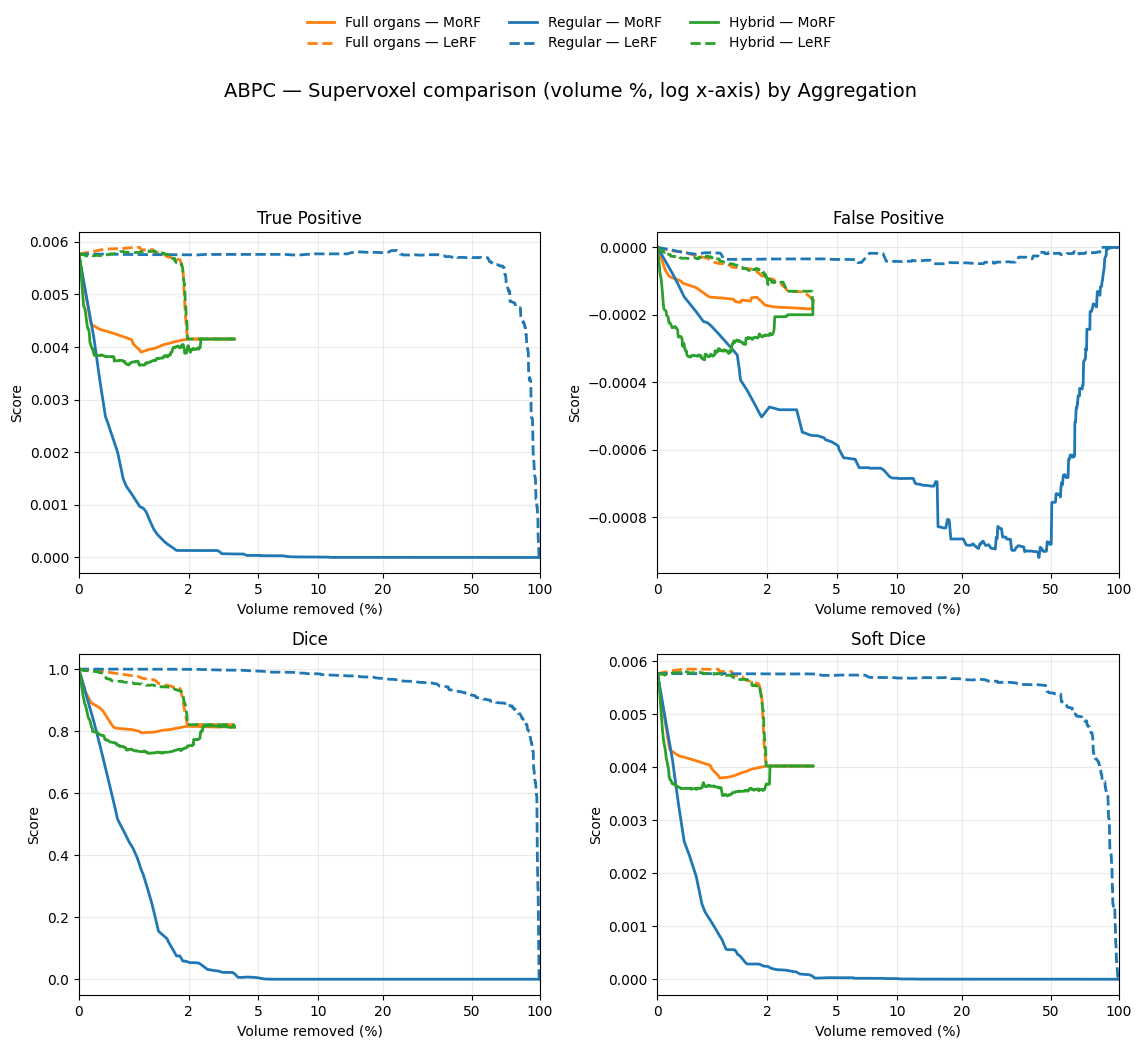

In [11]:
fig_cmp = dash.plot_supervoxel_comparison_from_grouped(
    sv_grouped,
    save=True,
    smoothing_window=0,
    band='quantile',
    quantile=0.25,
)